In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from src import *

---

<div align=center>

# RMS (Root Mean Square)

$$
RMS = \sqrt{ \frac{1}{T}\cdot \int_{t_0}^{t_0 + T} x^2(t)\cdot \mathrm{d}t}
$$

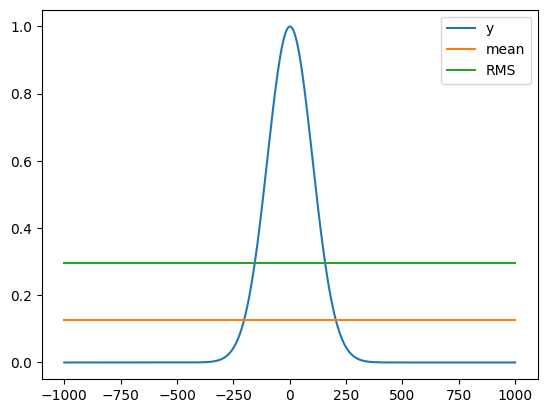

In [2]:
x = np.linspace(-1000,1000,1000)
y = gaussian(x, 1, 100)
m = np.mean(y)
RMS = np.sqrt(np.mean(y**2))

plt.plot(x, y, label="y")
plt.plot(x, np.ones_like(x)*m, label="mean")
plt.plot(x, np.ones_like(x)*RMS, label="RMS")
plt.legend()
plt.show()

$\rightarrow$ RMS is more sensitive to outliers

$\rightarrow$ In the context of perturbations, the usage of RMS instead of the mean is more relevant because a lower RMS also indicates a lower variance in the perturbations

<div align=center>

---

# Polynôme de Zernike

https://fr.wikipedia.org/wiki/Polyn%C3%B4me_de_Zernike

</div>


Pair:
$$\displaystyle Z_{n}^{m}(\rho ,\varphi )=R_{n}^{m}(\rho )\,\cos(m\,\varphi )\!$$
Impair:
$$\displaystyle Z_{n}^{-m}(\rho ,\varphi )=R_{n}^{m}(\rho )\,\sin(m\,\varphi ),\!$$

Avec:
$$
\displaystyle R_{n}^{m}(\rho )=\sum _{k=0}^{\tfrac {n-m}{2}}{\frac {(-1)^{k}\,(n-k)!}{k!\left({\tfrac {n+m}{2}}-k\right)!\left({\tfrac {n-m}{2}}-k\right)!}}\;\rho ^{n-2k}
$$

- $\rho$ est la distance au centre du disque unité (0 ≤ $\rho$ ≤ 1)
- $\varphi$ est l'angle polaire (0 ≤ $\varphi$ ≤ 2π)
- $n$ et $m$ sont des entiers tels que $n \geq m \geq 0$ et $n-m$ est pair

> A quoi ça sert ? 🤔

Une déformation de front d'onde dû à des aberrations optiques peut être décrite par une combinaison linéaire de polynômes de Zernike. Chaque polynôme de Zernike correspond à une aberration optique particulière.

$$
\displaystyle W(\rho ,\varphi )=\sum _{n=0}^{\infty }\sum _{m=-n}^{n}a_{n}^{m}\,Z_{n}^{m}(\rho ,\varphi )
$$

> Ok, et du coup, ça sert à quoi ? 🤔

Avoir cette forme décomposée (et généralement approximé en prenant un nombre fini de polynômes de Zernike) permet de déterminer formellement comment déformer un front d'onde pour compenser les aberrations optiques.

In [3]:
def zernike(n,m):
    X, Y = np.meshgrid(np.linspace(-1,1,100), np.linspace(-1,1,100))
    RHO = np.sqrt(X**2 + Y**2)
    PHI = np.arctan2(Y,X)

    def R(n,m,rho):
        R = np.zeros_like(rho)
        if (n-m)%2==0:
            for k in range((n-m)//2+1):
                R += (-1)**k \
                    * np.math.factorial(n-k) \
                    / (np.math.factorial(k) \
                    * np.math.factorial((n+m)//2-k) \
                    * np.math.factorial((n-m)//2-k)) \
                    * rho**(n-2*k)
        return R
    
    mask = RHO <= 1
    RHO = RHO * mask
    
    return R(n,m,RHO) * np.cos(m*PHI)

n_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=100,
    step=1,
    description='n:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

def get_min_max_m(n):
    if n%2==0:
        start = 0
    else:
        start=1
    return min(n,start), n

def get_m_slider():

    start, stop = get_min_max_m(n_slider.value)

    m_slider = widgets.IntSlider(
        value=start,
        min=start,
        max=stop,
        step=2,
        description='m:',
        disabled=True,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d'
    )

    return m_slider

def update_slider_minmax(slider, min, max):

    slider.disabled = False
    if min == max:
        slider.disabled = True
        max += 1

    if min < slider.max:
        slider.min = min
        slider.max = max
        return

    if max > slider.min:
        slider.max = max
        slider.min = min
        return
    
    raise ValueError("min and max are out of range")

m_slider = get_m_slider()

def update_m_slider(change):
    start, stop = get_min_max_m(n_slider.value)
    update_slider_minmax(m_slider, start, stop)
    
    m_slider.value = start

def plot_zernike(n,m):
    plt.title(f"Zernike({n},{m})")
    plt.imshow(zernike(n,m))
    plt.colorbar()
    plt.show()

n_slider.observe(update_m_slider, 'value')
_= widgets.interact(plot_zernike, n=n_slider, m=m_slider)

interactive(children=(IntSlider(value=0, continuous_update=False, description='n:'), IntSlider(value=0, contin…